# Clustering channels

We're going to apply a k-means clustering machine learning algorithm to the channels our node has had. <br>
Our inteniton is to recognize which features makes channels similar, to tag them appropriatley. <br>

## Clustering features

**Clustering features:**

- inbound forward attempts
- outbound forward attempts
- inbound forward successes
- outbound forwards successes
- peers number of channels
- response time of successful forwards
- peers centrality score 
- number of days the channel has been opened
- mean fee rate of transactions

**Consider the following:**

- Consider all data, not just from March
- Filter out channels linked to dead nodes
- Include channels with zero forward successes
- Divide forward metrics on the duration of the channel
- Filter out outlier channels

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import json
from pandas import json_normalize

In [4]:
def add_node_chan_info(df_nodes, df_channels):
    df_nodes = pd.concat([
        df_nodes,
        pd.DataFrame(columns=[
                'num_channels',
        ])
    ], sort=False)
    
    
    for index, node in df_nodes.iterrows():

        pub_key = node['pub_key']
        # obtain those channels that were opened by this specific node
        node1_channels = df_channels[df_channels.node1_pub == pub_key]
        
        
        # obtain those channels that were opened by other nodes
        node2_channels = df_channels[df_channels.node2_pub == pub_key]

        df_nodes.loc[index, 'num_channels'] = node1_channels.shape[0] + node2_channels.shape[0]

    return df_nodes

In [5]:
def add_pubkey2(series, channels):
    channels = channels.drop_duplicates(['chan_id'], keep='last')
    channels['chan_id'] = channels['chan_id'].astype(np.int64)
    series = series.reset_index().rename({'index':'outgoing_channel_id',
                                      0:'balanced_metric'}, axis=1)
    series['pubkey'] = ''
    out_chan_ids = series['outgoing_channel_id'].unique()
    
    for i in out_chan_ids:
        
        for z, j in channels[['chan_id', 'pub_key']].iterrows():
            
            if i == j['chan_id']:
                series.loc[series['outgoing_channel_id'] == i, 'pubkey'] = j['pub_key']
                
                break
    
    return series['pubkey']

In [6]:
def add_node_alias(peers_df, nodes):

    peers_df = peers_df.reset_index()
    peers_df['node_alias'] = ''

    nodes_pubkeys = peers_df['pub_key'].unique()
    
    for i in nodes_pubkeys:
        
        for ix, j in nodes[['pub_key', 'alias']].iterrows():
            
            if i == j['pub_key']:
                peers_df.loc[peers_df['pub_key'] == i, 'node_alias'] = j['alias']
                
                break
    peers_df = peers_df.set_index('pub_key')
    
    return peers_df['node_alias']

In [7]:
def get_avg_response_time(x):
    mean_dif = 0
    htlc_ids = x['outgoing_htlc_id'].unique()
    
    c = 0
    for i in htlc_ids:
        time = x[x['outgoing_htlc_id'] == i]['time'].values
        if len(time) <=1:
            continue
        dif = time[1] - time[0]
        mean_dif = mean_dif + dif
        c += 1
    if c == 0:
        return None
    return mean_dif/c

In [8]:
def divide_on_duration(x):
    i = x.index
    dur = copy_all_data.loc[i, 'active_time']
    return x/dur

In [9]:
def convert_ln_json_to_igraph(json_file_path):

    # Read JSON data
    graph_path = open(json_file_path, encoding='utf-8')
    graph_json = json.load(graph_path)
    
    # Create an empty graph
    G = igraph.Graph()
    
    # Parse and add nodes
    for node in graph_json['nodes']:
        G.add_vertex(
            node['pub_key'], 
            alias=node['alias'], 
            addresses=node['addresses'], 
            color=node['color'], 
            last_update=node['last_update']
        )
        
    # Parse and add edges
    for edge in graph_json['edges']:
        G.add_edge(
            edge['node1_pub'],
            edge['node2_pub'],
            channel_id=edge['channel_id'],
            chan_point=edge['chan_point'],
            last_update=edge['last_update'],
            capacity=edge['capacity'],
            node1_policy=edge['node1_policy'],
            node2_policy=edge['node2_policy']
        )
        
    return G

In [10]:
def bench_k_means(kmeans, name, data):
    """Benchmark to evaluate the KMeans initialization methods.

    Parameters
    ----------
    kmeans : KMeans instance
        A :class:`~sklearn.cluster.KMeans` instance with the initialization
        already set.
    name : str
        Name given to the strategy. It will be used to show the results in a
        table.
    data : ndarray of shape (n_samples, n_features)
        The data to cluster.
    """
    t0 = time()
    estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
    fit_time = time() - t0
    results = [name, fit_time, estimator[-1].inertia_]

    # The silhouette score requires the full dataset
    results += [
        metrics.silhouette_score(
            data,
            estimator[-1].labels_,
            metric="euclidean",
            sample_size=40,
        )
    ]

    # Show the results
    formatter_result = (
        "{:9s}\t{:.3f}s\t{:.0f}\t{:.3f}"
    )
    print(formatter_result.format(*results))
    
    return estimator.named_steps['kmeans'].labels_

In [11]:
# Open htlc dataset
htlc_path = '../Datos/htlc_2022-06-29.csv'
df_htlc = pd.read_csv(htlc_path)
df_htlc[['outgoing_channel_id', 'incoming_channel_id']] = df_htlc[['outgoing_channel_id', 
                                                                   'incoming_channel_id']].astype(np.int64)
# Filtering to have only forward events
mask = ((df_htlc['event_origin'] == 'FORWARD') | (df_htlc['event_origin'] == '3'))
htlc_forwards = df_htlc[mask]

# total fwd events
total_fws = htlc_forwards.copy()
# Time series
total_fws.time = pd.to_datetime(total_fws.time)
total_df = total_fws.set_index('time')
# filter to gave only Forward attempts
forward_attempts = total_df[total_df['event_type']=='ForwardEvent']

In [12]:
# Open forwards dataset
forwards_path = '../Datos/forwards_2022-06-29.csv'
df_forwards = pd.read_csv(forwards_path)
df_forwards[['outgoing_channel_id', 'incoming_channel_id']] = df_forwards[['outgoing_channel_id', 
                                                                           'incoming_channel_id']].astype(np.int64)
# Time series
timed_forwards = df_forwards.copy()
timed_forwards['time'] = pd.to_datetime(timed_forwards['time'])
timed_forwards.set_index('time', inplace=True)

In [13]:
# filter to have only settle_event type 
# This are the forward successes
forward_successes = total_df[total_df['event_type']=='SettleEvent']

# outbound metrics
out_forward_att = forward_attempts.groupby('outgoing_channel_id')['event_type'].aggregate('count')
out_forward_succ = df_forwards.groupby('outgoing_channel_id').size()
# inbound metrics
in_forward_att = forward_attempts.groupby('incoming_channel_id')['event_type'].aggregate('count')
in_forward_succ = df_forwards.groupby('incoming_channel_id').size()

In [14]:
# Node events dataset (node alias)
nodes_path = '../Datos/node_events_2022-06-29.csv'
df_nodes = pd.read_csv(nodes_path)

In [15]:
# Channel events dataset (chan id - pubkey)
channels_path = '../Datos/channel_events_2022-06-29.csv'
df_channels = pd.read_csv(channels_path)
df_channels['chan_id'] = df_channels['chan_id'].astype(np.int64)

In [16]:
# compute linked nodes metrics
all_chans = total_df['outgoing_channel_id'].unique() 
more = [i for i in total_df['incoming_channel_id'].unique() if i not in all_chans]
# all channels our node has had
all_chans = np.concatenate([all_chans,more])
# Peer nodes metrics
peers = pd.DataFrame(index=all_chans).reset_index()
# add linked node pubkey
peers['pub_key'] = add_pubkey2(peers, df_channels)
peers.set_index('pub_key', inplace=True)
# add linked node alias
peers['alias'] = ''
peers['alias'] = add_node_alias(peers, df_nodes)

In [18]:
# upload ln graph
# file_name = '../Datos/graph_metrics_2022-06-29.json'
# graph_data = open(file_name, encoding='utf8')
# graph_json = json.load(graph_data)
# # converting data to pd dfs
# nodes_graph = json_normalize(graph_json['nodes'])
# channels_graph = json_normalize(graph_json['edges'])
# channels_graph.channel_id = channels_graph.capacity.astype(int)
# channels_graph.capacity = channels_graph.capacity.astype(int)

**If it is the first time you run this notebook, uncomment the cell above and run it**.<br>
Then uncomment the cell below and run it.

In [ ]:
# ln_graph = add_node_chan_info(nodes_graph, channels_graph)

If it is the first time you run this notebook, uncomment the cell below and run it.

In [17]:
# ln_graph.to_csv('ln_graph.csv', encoding='utf-8')

In [18]:
# This cell is to upload the lightning network graph as a dataframe
# It's only gonna work if you have run the above cells once. If you have, you can comment those cells
# and stay with this one.
ln_graph = pd.read_csv('ln_graph.csv', index_col=0)

In [19]:
# Total number of channels a peer has
peers['num_channels'] = ln_graph.set_index('pub_key')['num_channels']
peers.rename({'index':'chan_id'}, inplace=True, axis=1)

In [20]:
# Response time of successful forwards
ids = total_df['outgoing_channel_id'].unique()
ixs = 0
for i in ids:
    mask1 = total_df['outgoing_channel_id'] == i
    the_chan = total_df[(mask1)]
    mask2 = ~the_chan['outgoing_htlc_id'].isin(the_chan[the_chan['event_type'] == 'ForwardFailEvent']['outgoing_htlc_id'].unique())
    mask3 = the_chan['event_type'].isin(['ForwardEvent', 'SettleEvent'])
    output = the_chan[mask3 & mask2]
    if ixs is 0:
        ixs = output.index.tolist()
    else:
        ixs = ixs + (output.index.tolist())
        
successful_forwards = total_df.loc[ixs,:]
mean_response_time = successful_forwards.reset_index().sort_values(by='time').groupby('outgoing_channel_id').apply(get_avg_response_time)

In [21]:
mean_response_time = mean_response_time.apply(lambda x: x.seconds + x.microseconds / 1e6)

In [22]:
features = ["pub_key","inbound_fw_att","outbound_fw_att",
            "inbound_successes","outbound_successes",
            "peers_channels","avg_response_time",
            "betweenness_centrality_score","active_time","out_fee_rate_mean"]
all_data = pd.DataFrame(index=all_chans, columns=features)

In [23]:
all_data.head(1)

,pub_key,inbound_fw_att,outbound_fw_att,inbound_successes,outbound_successes,peers_channels,avg_response_time,betweenness_centrality_score,active_time,out_fee_rate_mean
778530098852528128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
all_data.shape
# This are the number of channels and the features we're analysing.

(183, 10)

In [26]:
# JOIN FEATURES 
# outbound features
all_data['outbound_fw_att'] = out_forward_att
all_data['outbound_successes'] = out_forward_succ
# inbound features
all_data['inbound_fw_att'] = in_forward_att
all_data['inbound_successes'] = in_forward_succ

In [27]:
# avr response time for a successful forward
all_data['avg_response_time'] = mean_response_time
# match pub key
all_data['pub_key'] = peers.reset_index().set_index('chan_id')['pub_key']

In [28]:
# all_data.head(3)

In [29]:
# peers channels
all_data['peers_channels'] = peers.set_index('chan_id')['num_channels']

In [30]:
# Fee stats
forwards_path = '../Datos/forwards_2022-06-29.csv'
df_forwards = pd.read_csv(forwards_path)
df_forwards[['outgoing_channel_id', 'incoming_channel_id']] = df_forwards[['outgoing_channel_id', 
                                                                           'incoming_channel_id']].astype(np.int64)
timed_forwards = df_forwards.copy()
timed_forwards['time'] = pd.to_datetime(timed_forwards['time'])

timed_forwards.set_index('time', inplace=True)

fee_rate_out = (timed_forwards.set_index('outgoing_channel_id')['fee_msat'] / (timed_forwards.set_index('outgoing_channel_id')['outgoing_amount_msat']) *1000000)
fee_cols = 'out_fee_rate_mean'
all_data[fee_cols] = fee_rate_out.reset_index().groupby('outgoing_channel_id')[0].describe().loc[:,'mean']

In [31]:
# all_data.head(3)

In [32]:
import requests
from datetime import datetime
import time

In [33]:
# UNCOMMENT the cell above if it's the  first time you run the notebook.
# It interacts with mempool.space/api, so we should avoid running that cell 
# more times than necessary

In [34]:
# # Active time
# chans = df_channels.drop_duplicates(['chan_id'], keep='last')['chan_id'].unique()
# txs = []
# a = df_channels.drop_duplicates(['chan_id'], keep='last')
# for c in chans:
    
#     txs.append(a[a['chan_id'] == c]['chan_point'].values[0])
    
# a = a[a['chan_id'] != 0]
# d = { k:v for k, v in zip(a['chan_id'].values.tolist(), a['chan_point'].values.tolist())}
# # d is a dictionary where the keys are the chan ids and the values are the chan_points
# txs = d.values()
# txs = [tx[:-2] for tx in txs] # we care only for the chars before :
# txs_df = pd.DataFrame(d.items(), columns=['chan_id', 'tx_hash'])

# # Open time
# for i, tx in enumerate(txs):
#     request = requests.get('https://mempool.space/api/tx/'+ tx)
#     data = request.json()
#     block_time = data['status']['block_time']
#     b_date_time= datetime.fromtimestamp(data['status']['block_time'])
#     txs_df.loc[i,'block_time'] = block_time
#     txs_df.loc[i, 'date_time'] = b_date_time
#     time.sleep(0.2)
    
# print('done')
# # Close tx hash
# json_objs = a[a['event_type'] == 1]['event']
# close_txs = pd.DataFrame(index=range(json_objs.shape[0]), columns=['tx_hash', 'closing_tx_hash'])
# for i, c in enumerate(json_objs):
#     s = json.loads(c.replace("'", '"'))
#     try:
#         close_txs.loc[i,'tx_hash'] = s['channel_point']
#         close_txs.loc[i,'closing_tx_hash'] = s['closing_tx_hash']
#     except:
#         close_txs.loc[i,'tx_hash'] = s['Channel']['ClosedChannel']['channel_point']
#         close_txs.loc[i,'closing_tx_hash'] = s['Channel']['ClosedChannel']['closing_tx_hash']
# # Close time
# close_txs['close_block_time'] = None
# close_txs['close_date_time'] = None
# for i, tx in enumerate(close_txs['closing_tx_hash']):
#     request = requests.get('https://mempool.space/api/tx/'+ tx)
#     data = request.json()
#     block_time = data['status']['block_time']
#     b_date_time= datetime.fromtimestamp(data['status']['block_time'])
#     close_txs.loc[i,'close_block_time'] = block_time
#     close_txs.loc[i, 'close_date_time'] = b_date_time
#     time.sleep(0.2)
    
# print('done')
# # Compute time difference
# time_diff = close_txs.set_index('tx_hash')['close_date_time'] - txs_df.set_index('tx_hash')['date_time']
# last_date = pd.datetime(2022, 6, 29)
# open_channels = time_diff[time_diff.isna()].index
# time_diff[time_diff.isna()] = last_date - txs_df[txs_df['tx_hash'].isin(open_channels)].set_index('tx_hash')['date_time']
# time_diff.name = 'time_difference'
# txs_time_info = pd.merge(txs_df.set_index('tx_hash'), time_diff, right_index=True, left_index=True)
# txs_time_info = txs_time_info.reset_index().set_index('chan_id')

In [35]:
# Uncomment and run the cell below once, to save the information retrieved from the api as a dataframe

In [36]:
# txs_time_info.to_csv('txsTimeInfo.csv', encoding='utf-8')

In [37]:
# This cell will only work if the cells above have been run once. 
# After, you can leave commented those cells and stay with this one
active_time_s = pd.read_csv('txsTimeInfo.csv', index_col=0)

In [38]:
all_data['active_time'] = active_time_s['time_difference']

In [39]:
# all_data.head(3)

In [40]:
# transform active time feature to timedelta object
all_data['active_time'] = all_data['active_time'].transform(lambda x: pd.Timedelta(x))

In [41]:
# Number of days a channel has been opened
copy_all_data = all_data.copy()
copy_all_data['active_time'] = copy_all_data['active_time'].transform(lambda x: x.days)
all_data['active_time'] = copy_all_data['active_time']

In [42]:
# Dividing forward metrics on the duration of a channel
f_metrics = ['inbound_fw_att', 'outbound_fw_att', 'inbound_successes',
       'outbound_successes']
all_data[f_metrics] = copy_all_data[f_metrics].apply(divide_on_duration)

In [43]:
# remove active_time feature
all_data.drop('active_time', axis=1, inplace=True)

In [44]:
import igraph

The following is for computing the betweenness centrality score of all node in the LN graph. <br>
You may uncomment the 3 following cells once. The centrality score will be saved in csv file, so that no you don't need to re do this computations the next time you open the notebook, as they take their time. 

In [45]:
# # Compute peers betweenness_centrality_score
# lngraph_path = '../Datos/graph_metrics_2022-06-29.json'
# i_graph = convert_ln_json_to_igraph(lngraph_path)

In [46]:
# # betweenness centrality score
# i_graph.vs["bs"] = i_graph.betweenness()
# # df of centrality score
# centrality_score = pd.Series(data=i_graph.vs['bs'], index=i_graph.vs['name'], name='centrality_score')

In [47]:
# centrality_score.to_csv('centrality_score.csv', encoding='utf-8')

In [48]:
# This cell will only work if the cells above have been run once.
centrality_score = pd.read_csv('centrality_score.csv', index_col=0)

In [49]:
centrality_score.head()

,centrality_score
020003b9499a97c8dfbbab6b196319db37ba9c37bccb60477f3c867175f417988e,23764.735040
0200072fd301cb4a680f26d87c28b705ccd6a1d5b00f1b5efd7fe5f998f1bbb1f1,70341.376628
0200081eaa41b5661d3b512f5aae9d6abfb11ba1497a354e9217d9a18fbaa1e76b,5123.376824
020016201d389a44840f1f33be29288952f67c8ef6b3f98726fda180b4185ca6e2,20790.546679
02001828ca7eb8e44d4d78b5c1ea609cd3744be823c22cd69d895eff2f9345892d,0.000000


In [50]:
# append centrality score to features
all_data = all_data.reset_index().set_index('pub_key')
all_data['betweenness_centrality_score'] = centrality_score
all_data = all_data.reset_index().rename({'index':'chan_id'}, axis=1).set_index('chan_id')

In [51]:
# all_data.head(3)

In [52]:
# clear noise from data

In [53]:
all_data = all_data[all_data['pub_key'] != '']

In [54]:
all_data.isna().sum()
# There is a lot of missing data

pub_key                          0
inbound_fw_att                  15
outbound_fw_att                 12
inbound_successes               10
outbound_successes              10
peers_channels                  17
avg_response_time               25
betweenness_centrality_score    17
out_fee_rate_mean               10
dtype: int64

In [55]:
# filter out channels linked to dead nodes
all_data = all_data[~all_data['peers_channels'].isna()]

In [56]:
# fill na values with zeros
all_data.fillna(0, inplace=True)

In [57]:
all_data.isna().sum()

pub_key                         0
inbound_fw_att                  0
outbound_fw_att                 0
inbound_successes               0
outbound_successes              0
peers_channels                  0
avg_response_time               0
betweenness_centrality_score    0
out_fee_rate_mean               0
dtype: int64

In [58]:
# remove node duplicates
all_data = all_data.sort_values(by='outbound_fw_att').drop_duplicates(['pub_key'], keep='last')

In [59]:
# removing avg response time
features = all_data.drop('avg_response_time', axis=1)
# Although it's considered an important feature, in our case it contributed to noise more than it helped identify anything

In [60]:
# shuffle rows
features = features.sample(frac=1)

In [ ]:
# The following cells were used to filter out outliers. You can modify them, or simply not use them.

In [61]:
# filter out LOOP
# features = features[features['pub_key']!='021c97a90a411ff2b10dc2a8e32de2f29d2fa49d41bfbb52bd416e460db0747d0d']

In [62]:
# filter out BOLTZ
# features = features[features['pub_key']!='026165850492521f4ac8abd9bd8088123446d126f648ca35e60f88177dc149ceb2']

In [63]:
# features.shape

In [64]:
# filter out zero fee routing
# features = features[features['pub_key']!='038fe1bd966b5cb0545963490c631eaa1924e2c4c0ea4e7dcb5d4582a1e7f2f1a5']

In [65]:
# filter out c.otto
# features = features[features['pub_key']!='027ce055380348d7812d2ae7745701c9f93e70c1adeb2657f053f91df4f2843c71']

In [66]:
# filter out noserver4u
# features = features[features['pub_key']!='0253064653c3c2b52ea76201a24771580ac562902fb603b7b077c347a2420d7190']

In [68]:
# features.shape

# Building the Clustering Model

In [69]:
from sklearn.cluster import KMeans
from time import time
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [70]:
data = features.drop('pub_key', axis=1)

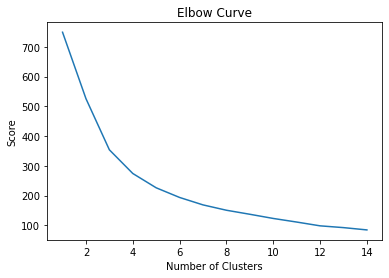

In [71]:
from sklearn.cluster import KMeans
Nc = range(1, 15)
# estimator = make_pipeline(StandardScaler(), kmeans).fit(data)
kmeans = [make_pipeline(StandardScaler(), KMeans(n_clusters=i, init = 'k-means++', random_state=42)) for i in Nc]

score = [kmeans[i].fit(data).named_steps['kmeans'].inertia_ for i in range(len(kmeans))]
score
plt.plot(Nc,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [72]:
clusters = 6 # change the number of clusters however you want

In [73]:
kmeans = KMeans(init="k-means++", n_clusters=clusters, n_init=10, random_state=0)
print(42 * "_")
print("init\t\ttime\tinertia\tsilhouette")
labels = bench_k_means(kmeans=kmeans, name="k-means++", data=data)
print(42 * "_")

__________________________________________
init		time	inertia	silhouette
k-means++	0.035s	193	-0.520
__________________________________________


In [74]:
clustered_data = data.copy()
clustered_data['cluster'] = labels

In [75]:
# add pub_key
clustered_data['pub_key'] = features['pub_key']
clustered_data.head(1)

,inbound_fw_att,outbound_fw_att,inbound_successes,outbound_successes,peers_channels,betweenness_centrality_score,out_fee_rate_mean,cluster,pub_key
chan_id,,,,,,,,,
805781494517006336,2.235294,23.544118,0.617647,3.161765,792.0,2.636625e+06,17.646142,2,0260fab633066ed7b1d9b9b8a0fac87e1579d1709e874d...


In [76]:
# add node alias
clustered_data = clustered_data.reset_index().set_index('pub_key')
clustered_data['node_alias'] = add_node_alias(clustered_data, df_nodes)
clustered_data = clustered_data.reset_index().set_index('chan_id')

In [88]:
# THIS IS ONLY TO HIDE OUR CHANNEL IDS, for private reasons
# You may comment this line
clustered_data = clustered_data.reset_index(drop=True)

In [89]:
# clustered_data

In [90]:
# Change this cell depending on the number of clusters you decided
cluster_1 = clustered_data[clustered_data['cluster'] == 0]
cluster_2 = clustered_data[clustered_data['cluster'] == 1]
cluster_3 = clustered_data[clustered_data['cluster'] == 2]
cluster_4 = clustered_data[clustered_data['cluster'] == 3]
cluster_5 = clustered_data[clustered_data['cluster'] == 4]
cluster_6 = clustered_data[clustered_data['cluster'] == 5]

In [91]:
cluster_1

,pub_key,inbound_fw_att,outbound_fw_att,inbound_successes,outbound_successes,peers_channels,betweenness_centrality_score,out_fee_rate_mean,cluster,node_alias
13,030ed0e8c35b473e0cdf3b384262688be36a2a7bb61ecf...,90.141667,9.108333,4.633333,5.008333,46.0,10805.095053,12.525668,0,FriendsWithBenefits
63,035542f0f213a5b6e985dff0e0fd973da01bd77325d442...,0.000000,1.263158,5.763158,4.078947,104.0,16653.632608,35.152831,0,LNConnect
100,022eb09a7993a0edde69537b420f4119c0de833e0ee476...,18.019305,8.567568,3.042471,5.204633,48.0,13692.367373,16.214064,0,Ngu Technologies
104,023c46da79ddd8949659e7077b5b0a46add5a7d153f2b9...,59.564706,41.929412,8.082353,4.882353,20.0,3243.076174,52.802198,0,Morphy
105,03dc13c8c4b2ad8397855cf377fc34085ffbf816ef85df...,59.727273,30.031818,3.890909,2.604545,148.0,53188.764601,22.466395,0,indomitusBTC


In [92]:
cluster_2

,pub_key,inbound_fw_att,outbound_fw_att,inbound_successes,outbound_successes,peers_channels,betweenness_centrality_score,out_fee_rate_mean,cluster,node_alias
20,02c10ada6c6bed574f216d4decb799743921da2ed13dc5...,0.117647,2.241830,0.045752,0.091503,275.0,2.616505e+05,357.809006,1,UmbrelGuy369
24,03a503d8e30f2ff407096d235b5db63b4fcf3f89a653ac...,0.000000,10.617647,0.044118,0.102941,346.0,1.965434e+06,388.570649,1,Milky Way
38,02fc1f8c244c9d275f999e6f0ce02f8e46d8f31864e9c8...,0.456250,3.200000,0.037500,0.068750,66.0,5.179739e+04,297.255878,1,MCMXCIII
39,0309cb0b504a5e2e29430fc327ee499c6b9b9ac226f561...,2.604938,6.679012,0.069959,0.074074,63.0,2.882497e+04,491.647407,1,HeavyBags.LN
71,033d8656219478701227199cbd6f670335c8d408a92ae8...,2.105932,12.881356,0.050847,0.262712,945.0,3.181767e+06,657.222110,1,bfx-lnd0
81,02fc63f7b07cc69c756d432f77ce36ce4e5dbe24f43f36...,0.003650,0.072993,0.010949,0.025547,16.0,2.720962e+03,385.690881,1,JDs.Connection
87,03cde60a6323f7122d5178255766e38114b4722ede08f7...,1.817021,0.382979,0.110638,0.080851,728.0,1.836291e+06,703.032014,1,bfx-lnd1
96,0382b31dcff337311bf919411c5073c9c9a129890993f9...,0.669683,0.126697,0.122172,0.018100,58.0,6.466944e+04,494.999929,1,lnnodeinsight.com


In [93]:
cluster_3

,pub_key,inbound_fw_att,outbound_fw_att,inbound_successes,outbound_successes,peers_channels,betweenness_centrality_score,out_fee_rate_mean,cluster,node_alias
0,0260fab633066ed7b1d9b9b8a0fac87e1579d1709e874d...,2.235294,23.544118,0.617647,3.161765,792.0,2.636625e+06,17.646142,2,southxchange.com
2,03ed6942f3a32b143b3479b85ed64453c9b7fbd2057ea1...,0.625000,16.022059,0.125000,0.139706,3.0,6.518385e+02,83.679827,2,simplecrypto.app-learning.com
3,0239e4dc85543cd84b712850072dc5e1bf0190c44b64db...,4.241379,7.459770,0.770115,0.586207,78.0,6.705238e+04,16.109769,2,RoutingHub⚡
5,036da0201ba1f16a2089d1e17a8fe236114adef33bfff5...,4.768000,0.844000,0.080000,0.308000,71.0,3.290354e+04,81.763051,2,node3-us-east2
6,0385218f0e307b6a0e989d2a717d346942d96b4fd550e9...,0.400000,0.000000,0.000000,0.000000,86.0,6.013501e+04,0.000000,2,ln1.satoshilabs.com
...,...,...,...,...,...,...,...,...,...,...
98,023e09c43b215bd3dbf483bcb409da3322ea5ea3b046f7...,0.197740,2.587571,0.005650,0.005650,85.0,3.686295e+04,9.966466,2,MerchantConnectHUB
99,03a62821af072e640e51187000fd83d4dca94d4c8ecdcd...,1.065844,1.995885,0.012346,0.082305,34.0,2.418207e+04,15.581828,2,kTONe
101,037659a0ac8eb3b8d0a720114efc861d3a940382dcfa14...,0.817797,1.165254,0.216102,2.080508,1186.0,3.873107e+06,139.352168,2,ln.nicehash.com [Nicehash]
102,03006fcf3312dae8d068ea297f58e2bd00ec1ffe214b79...,0.118644,0.000000,0.021186,0.004237,33.0,6.862488e+04,234.954806,2,Amboss.Space


In [94]:
cluster_4

,pub_key,inbound_fw_att,outbound_fw_att,inbound_successes,outbound_successes,peers_channels,betweenness_centrality_score,out_fee_rate_mean,cluster,node_alias
19,0242a4ae0c5bef18048fbecf995094b74bfb0f7391418d...,8.229730,25.702703,0.855856,0.342342,1879.0,1.471156e+07,22.126127,3,CoinGate
32,035e4ff418fc8b5554c5d9eea66396c227bd429a3251c8...,0.127119,0.563559,0.088983,0.860169,2584.0,1.692406e+07,242.821225,3,WalletOfSatoshi.com
61,03864ef025fde8fb587d989186ce6a4a186895ee44a926...,0.004184,1.046025,0.025105,0.129707,2977.0,2.531770e+07,113.251270,3,ACINQ


In [95]:
cluster_5

,pub_key,inbound_fw_att,outbound_fw_att,inbound_successes,outbound_successes,peers_channels,betweenness_centrality_score,out_fee_rate_mean,cluster,node_alias
1,0326e692c455dd554c709bbb470b0ca7e0bb04152f777d...,62.800000,55.944444,3.222222,1.788889,260.0,2.428039e+05,21.821531,4,allNice
7,034a879c36f418cb5b44b6903b3c6c1cfb5f4beb1e79b9...,27.787500,99.431250,1.581250,2.537500,170.0,1.091211e+05,22.751617,4,pedroLND
9,0298f6074a454a1f5345cb2a7c6f9fce206cd0bf675d17...,94.148305,137.652542,3.008475,1.927966,878.0,3.999316e+06,21.003898,4,BCash_Is_Trash
11,0290b992ad57328eccde9d51056ceae671de6f73cce692...,85.833333,148.416667,2.911111,3.194444,56.0,4.999395e+03,18.771047,4,Findel_LN
23,02b0172bb38617fa3afdb69664468b492d5a21062a4fa8...,22.056522,74.813043,0.526087,0.486957,138.0,3.636867e+05,27.127528,4,Nightling 🌙
33,02f324df7694f57b7d800d5a64f62fb226eabc8fbacb99...,22.276074,143.177914,2.374233,3.092025,317.0,4.969496e+05,18.732591,4,02f324df7694f57b7d80
49,0392cdd6a22ea90bb08017304c785b44774f3056230a03...,108.966387,68.394958,1.441176,2.096639,61.0,5.747818e+04,20.588993,4,UltraRunner
59,03271338633d2d37b285dae4df40b413d8c6c791fbee77...,36.213740,61.625954,2.152672,1.679389,333.0,4.831773e+05,21.017881,4,lnmarkets.com
70,02f94c8c175b002c6421f7e97f11f3ce846d2fd7d88a2b...,13.854545,60.590909,1.340909,2.463636,231.0,1.224478e+05,18.022746,4,BankoftheSovereignIndividual
89,0337694505123a12a8fadd95523dcc235898ad3b80a06e...,12.020134,102.657718,0.624161,0.818792,318.0,4.684052e+05,51.303956,4,Dagnela 🦄 Hunter


In [96]:
cluster_6

,pub_key,inbound_fw_att,outbound_fw_att,inbound_successes,outbound_successes,peers_channels,betweenness_centrality_score,out_fee_rate_mean,cluster,node_alias
4,021de24abe711f54e4eaa7e5ec37330edec9a4dcb1d09b...,45.306306,1.878378,1.121622,0.486486,48.0,4541.414759,37.117832,5,AVATAR
37,0294fd62bc6f4ad2804dfb01237baaf8b8dd5646cf6063...,66.382199,15.293194,0.476440,0.523560,147.0,64032.933719,27.196887,5,Cowa Lightning
46,037172d2110c4148d6ed0c2790ec8be948458022425dce...,38.371429,23.914286,0.285714,0.342857,88.0,46481.503338,9.247492,5,AQUARIOUS
50,02ec921faa245b5813385e04a51a6f0e2d99a570ff820b...,180.177778,18.725926,0.725926,1.251852,77.0,96293.481530,29.196212,5,Gewitterwoelkchen
51,0288f320d25b20df0578af737ea951c1c3adcc4e8cd908...,73.078125,7.312500,1.843750,0.953125,76.0,50362.925571,18.771647,5,cork
52,03cda3c7f11c0f63806b4910c7e00d133bc942fe66512f...,55.799087,6.602740,1.324201,1.118721,126.0,84696.851550,25.653654,5,HoernchenLightning
55,0250baf7a558091eb9c93f43d595b795db61bd2b55ca01...,42.632653,16.469388,0.455782,1.333333,119.0,33155.932685,28.430756,5,Peeky
64,02826f50035eca93c7ebfbad4f9621a8eb201f4e28f994...,52.635088,33.582456,0.480702,0.470175,57.0,9916.107894,26.600474,5,hippiesabotage
74,03ac61c971d146787a036f75e80a9fbede238a75d0c396...,59.638889,19.451389,0.347222,0.395833,142.0,236907.149608,31.206389,5,Thrash.at
91,03d4e028a0d4a90868ec202ab684fb0085779defea9ca7...,46.296167,4.383275,0.787456,0.864111,62.0,39656.556531,149.898626,5,SWISS.SOVEREIGN


In [368]:
# cluster_1.to_csv('cluster1_k6.csv', encoding='utf-8')
# cluster_2.to_csv('cluster2_k6.csv', encoding='utf-8')
# cluster_3.to_csv('cluster3_k6.csv', encoding='utf-8')
# cluster_4.to_csv('cluster4_k6.csv', encoding='utf-8')
# cluster_5.to_csv('cluster5_k6.csv', encoding='utf-8')

Here, we used 6 clusters to group the data based on the similarities of their features. Let's resume what we see:
1. Cluster 2 gathers all the channels with high fee rate, where we can see some exchanges.
2. Cluster 4 groups the channels linked to very big central nodes.
3. Cluster 3 is the biggest group.
4. The rest of the groups are very similar. They all seem to be balanced, and to have high activity. The main differences between the channels of those groups are the number of channels their peers have, and the betweenness centrality score of their peers.